<h1>Analyse des Garbage Collectors</h1>

<h3>Importieren der Bibliotheken</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu

<h3>Funktion zum Laden der Daten</h3>

In [2]:
def load_gc_data(java_version, dataset_name):
    filepath = f"initial_data/{dataset_name}_results_{java_version}.csv"
    # Lesen der Daten
    data = pd.read_csv(filepath)
    # Entfernen der zweiten Spalte (Dauer in ms)
    data = data.drop(columns=[data.columns[1]])
    # Setzen der ersten Spalte (Durchlauf) als Index
    data.set_index(data.columns[0], inplace=True)
    return data

<h3>Definition der Datensätze und Java-Versionen</h3>

In [3]:
# Definition der Datensätze und Java-Versionen
datasets_names = ["Sphere", "Floor", "Bunny", "Terrain_1", "Terrain_2"]
java_versions = ["8", "21"]

# Erstellen des Ausgabeverzeichnisses, falls es nicht existiert
output_dir = "combined_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

<h3>Funktion zum Laden und Zusammenführen der Datensätze</h3>

In [4]:
def load_and_merge(dataset_name):
    java_8_df = load_gc_data("8", dataset_name)
    java_21_df = load_gc_data("21", dataset_name)
    
    merged_df = pd.concat([java_8_df, java_21_df], axis=1)
    
    # Hinzufügen neuer Spalten für GC_Collections und GC_Zeit
    merged_df['GC_Collections_8'] = merged_df['PS Scavenge Collections'] + merged_df['PS MarkSweep Collections']
    merged_df['GC_Zeit_8'] = merged_df['PS Scavenge Zeit'] + merged_df['PS MarkSweep Zeit']
    merged_df['GC_Collections_21'] = (merged_df['G1 Young Generation Collections'] + 
                                       merged_df['G1 Concurrent GC Collections'] + 
                                       merged_df['G1 Old Generation Collections'])
    merged_df['GC_Zeit_21'] = (merged_df['G1 Young Generation Zeit'] + 
                                merged_df['G1 Concurrent GC Zeit'] + 
                                merged_df['G1 Old Generation Zeit'])
    
    return merged_df

<h3>Zusammenführen und Speichern der Datensätze</h3>

In [5]:
# Zusammenführen und Speichern der Datensätze für jedes Modell
for dataset_name in datasets_names:
    merged_df = load_and_merge(dataset_name)
    output_path = os.path.join(output_dir, f"gc_{dataset_name}_combined_data.csv")
    merged_df.to_csv(output_path)

<h3>Definition der Spalten für Sammlungen und Zeiten</h3>

In [6]:
collections_columns = [
    "PS Scavenge Collections (Java 8)", "PS MarkSweep Collections (Java 8)", 
    "G1 Young Generation Collections (Java 21)", "G1 Concurrent GC Collections (Java 21)", 
    "G1 Old Generation Collections (Java 21)"
]

times_columns = [
    "PS Scavenge Zeit (Java 8)", "PS MarkSweep Zeit (Java 8)", 
    "G1 Young Generation Zeit (Java 21)", "G1 Concurrent GC Zeit (Java 21)", 
    "G1 Old Generation Zeit (Java 21)"
]

<h3>Erstellen und Speichern der Plots Alle GC</h3>

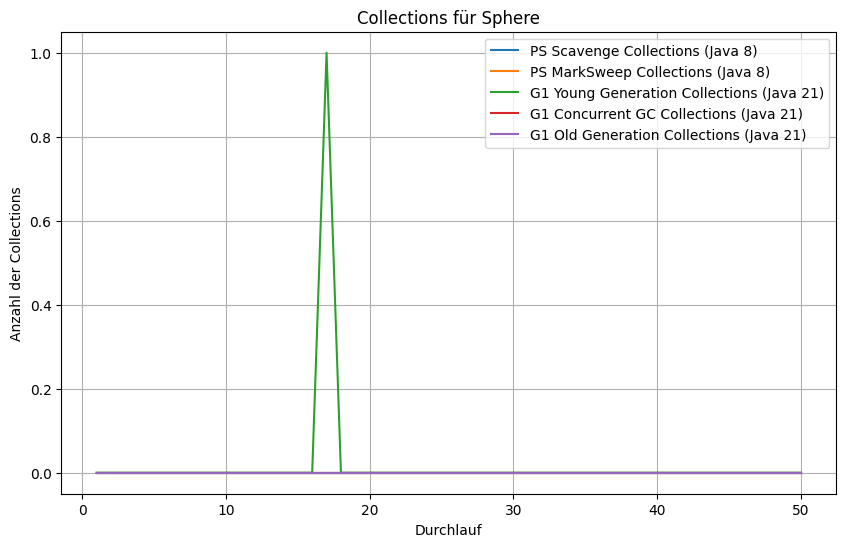

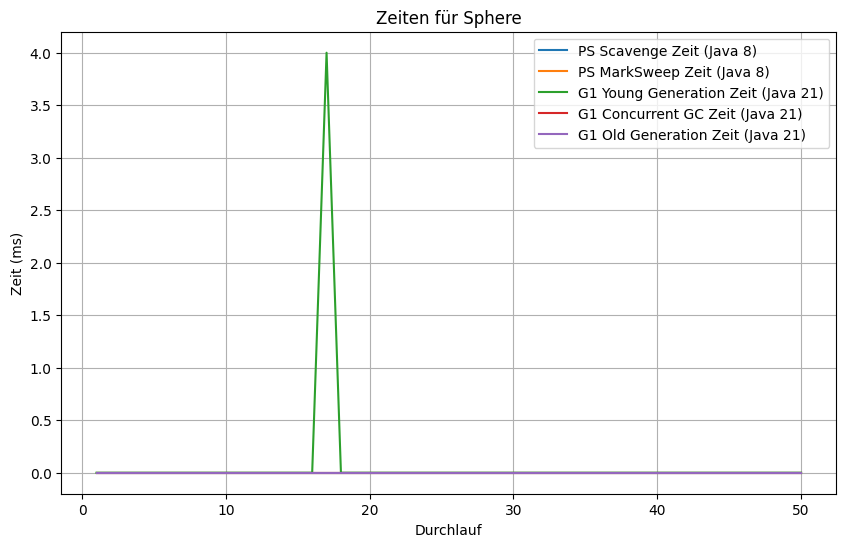

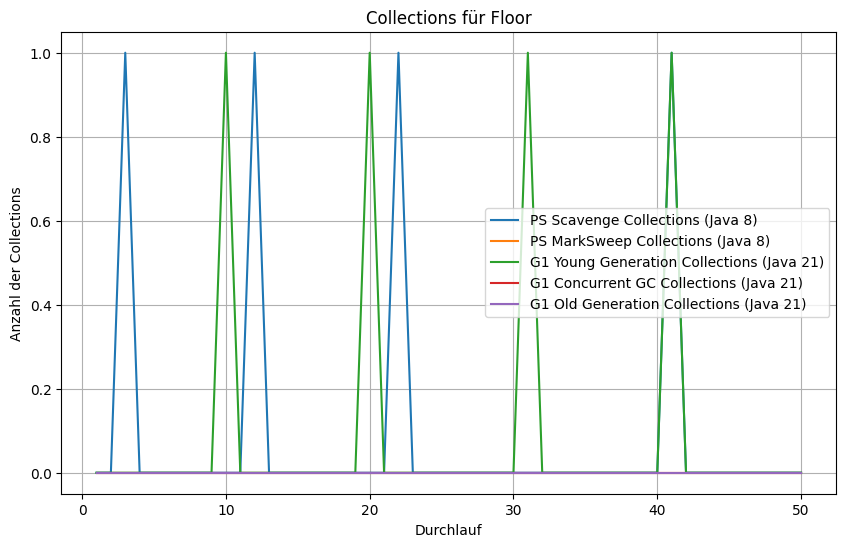

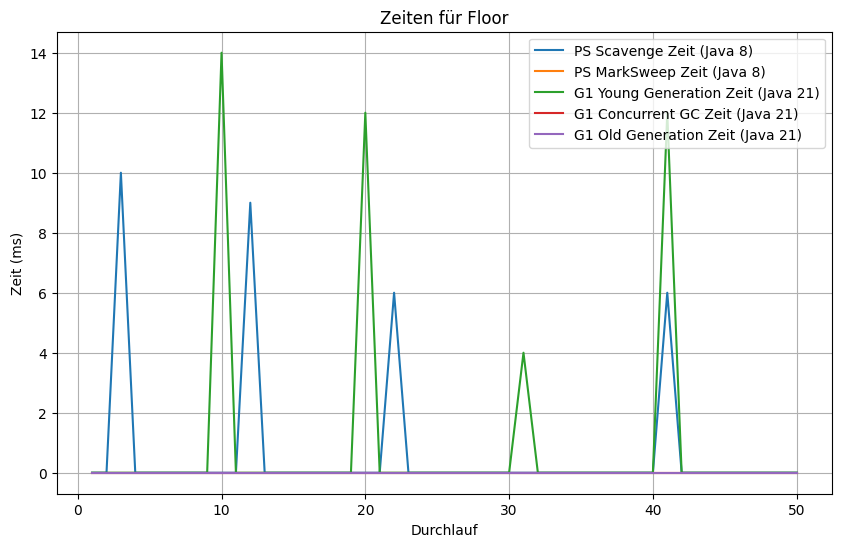

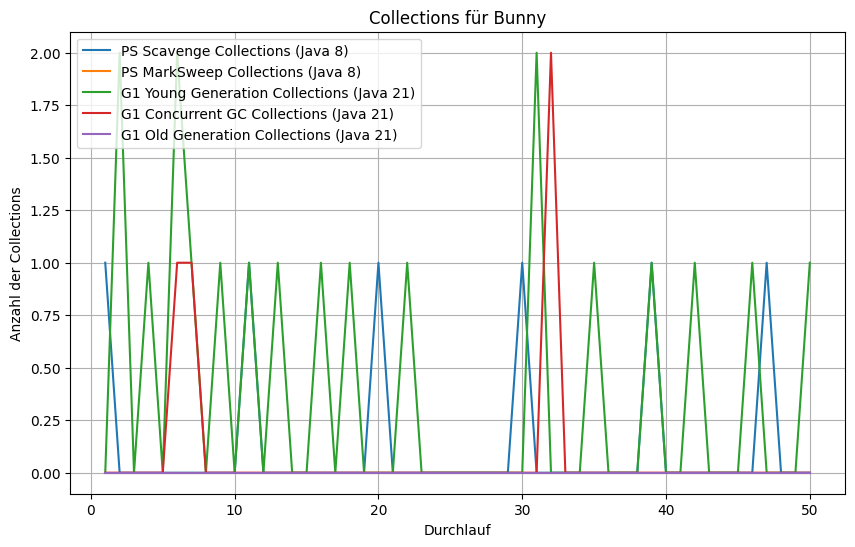

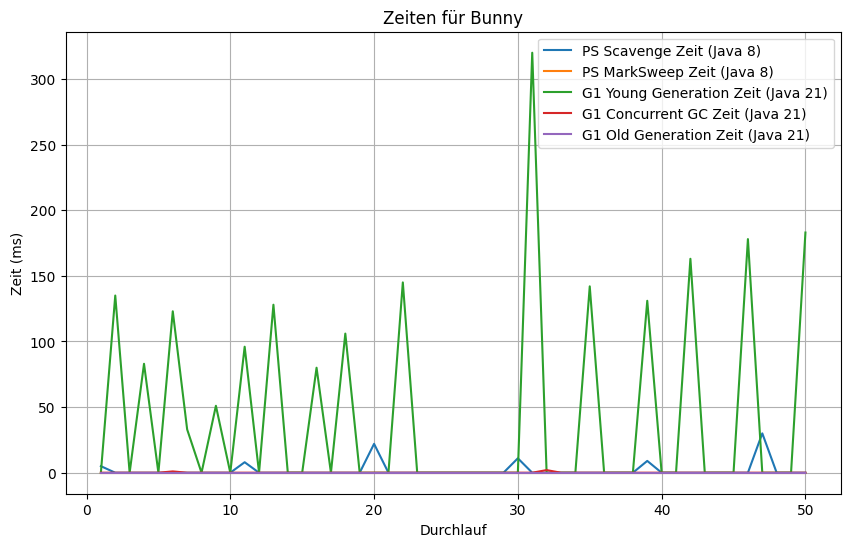

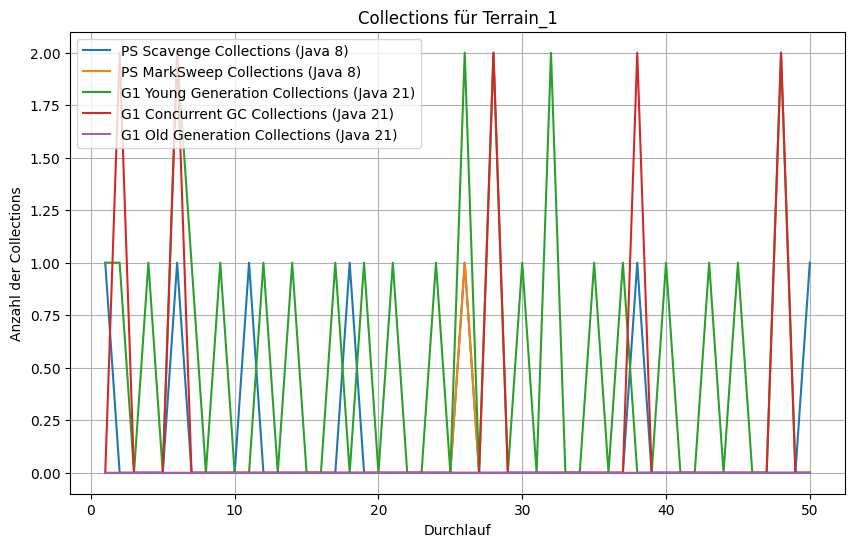

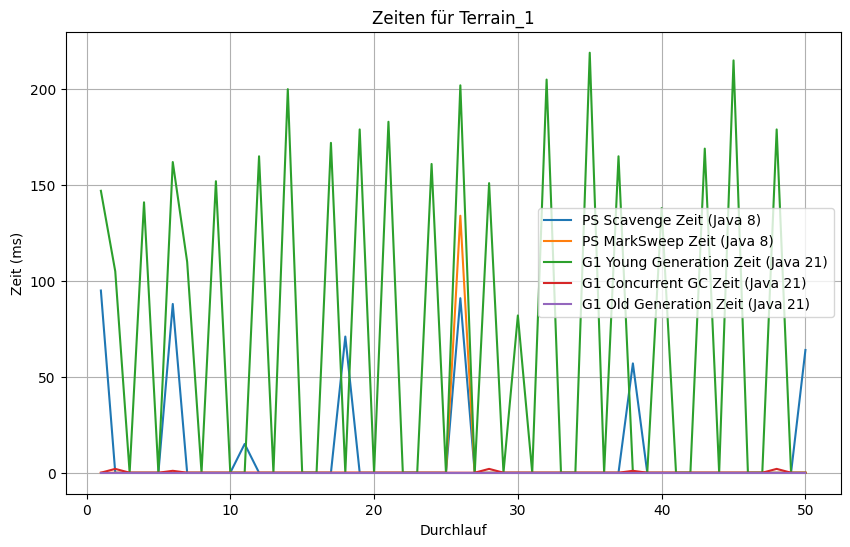

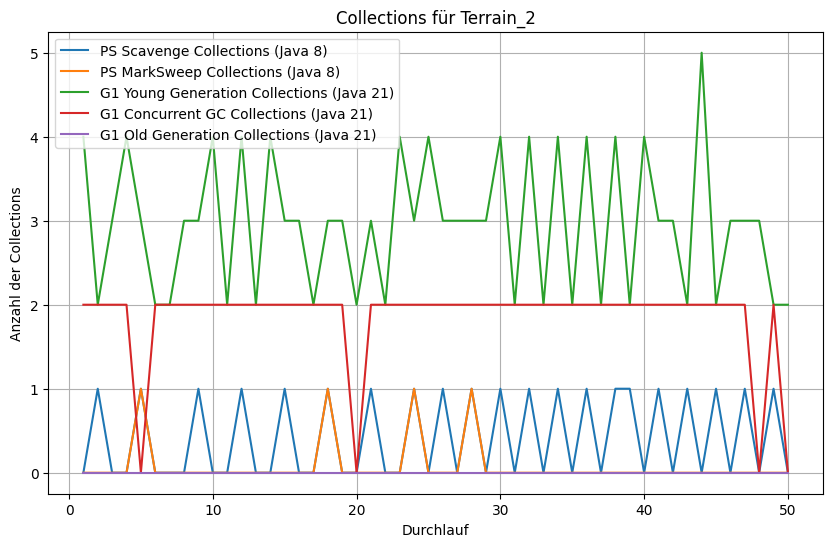

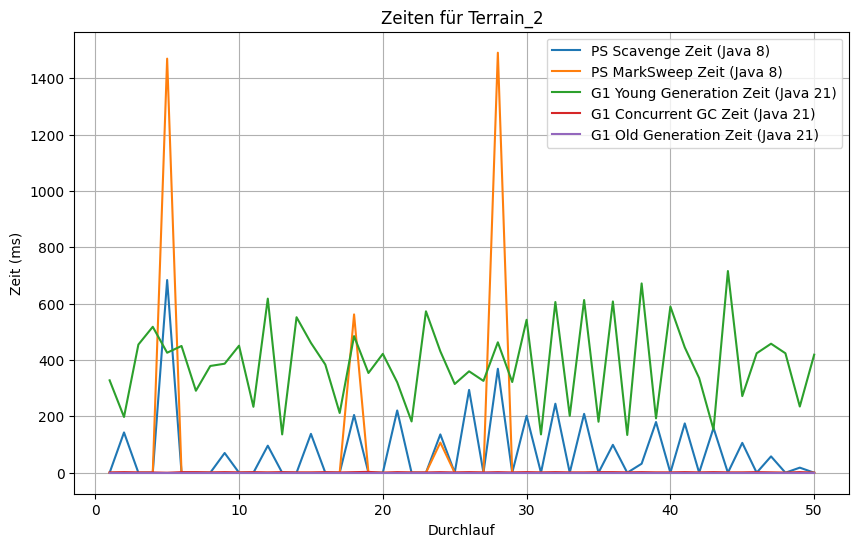

In [7]:
# Funktion zum Erstellen und Speichern der ursprünglichen Plots
def create_plots(dataset_name, df):
    # Umbenennen der Spalten für bessere Beschriftung
    df = df.rename(columns={
        "PS Scavenge Collections": "PS Scavenge Collections (Java 8)", 
        "PS MarkSweep Collections": "PS MarkSweep Collections (Java 8)", 
        "G1 Young Generation Collections": "G1 Young Generation Collections (Java 21)", 
        "G1 Concurrent GC Collections": "G1 Concurrent GC Collections (Java 21)", 
        "G1 Old Generation Collections": "G1 Old Generation Collections (Java 21)",
        "PS Scavenge Zeit": "PS Scavenge Zeit (Java 8)", 
        "PS MarkSweep Zeit": "PS MarkSweep Zeit (Java 8)", 
        "G1 Young Generation Zeit": "G1 Young Generation Zeit (Java 21)", 
        "G1 Concurrent GC Zeit": "G1 Concurrent GC Zeit (Java 21)", 
        "G1 Old Generation Zeit": "G1 Old Generation Zeit (Java 21)"
    })
    
    # Plot für Sammlungen
    plt.figure(figsize=(10, 6))
    for column in collections_columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column)
    plt.xlabel('Durchlauf')
    plt.ylabel('Anzahl der Collections')
    plt.title(f'Collections für {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'performance_comparison/all_gc_collections_comparison_{dataset_name}.png')
    plt.show()
    
    # Plot für Zeiten
    plt.figure(figsize=(10, 6))
    for column in times_columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column)
    plt.xlabel('Durchlauf')
    plt.ylabel('Zeit (ms)')
    plt.title(f'Zeiten für {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'performance_comparison/all_gc_time_comparison_{dataset_name}.png')
    plt.show()

# Laden und Erstellen der Plots für jedes Datenset
for dataset_name in datasets_names:
    df = pd.read_csv(f'combined_data/gc_{dataset_name}_combined_data.csv', index_col=0)
    create_plots(dataset_name, df)

<h3>Erstellen und Speichern der Vergleichsplots Java 8 vs Java 21</h3>

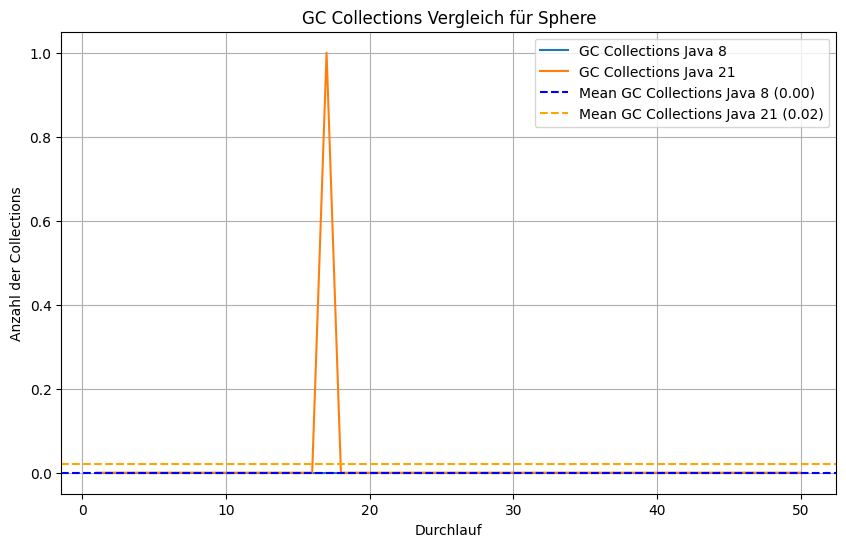

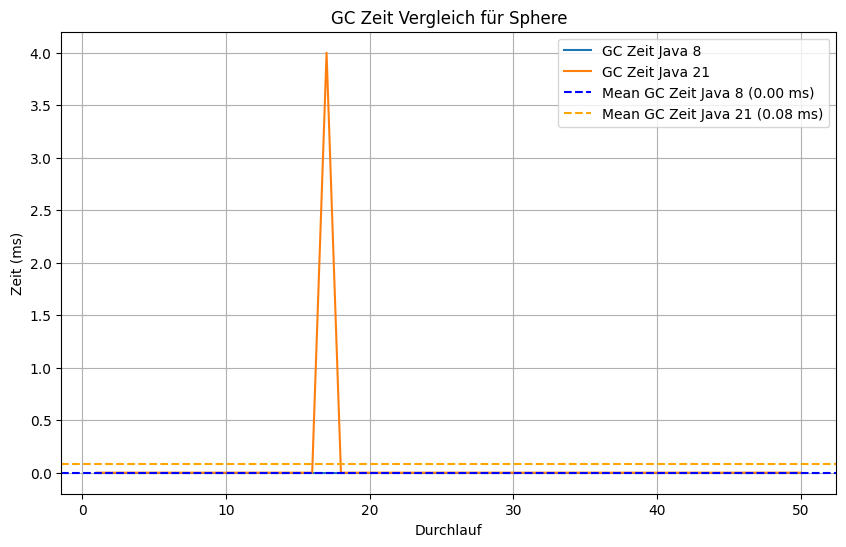

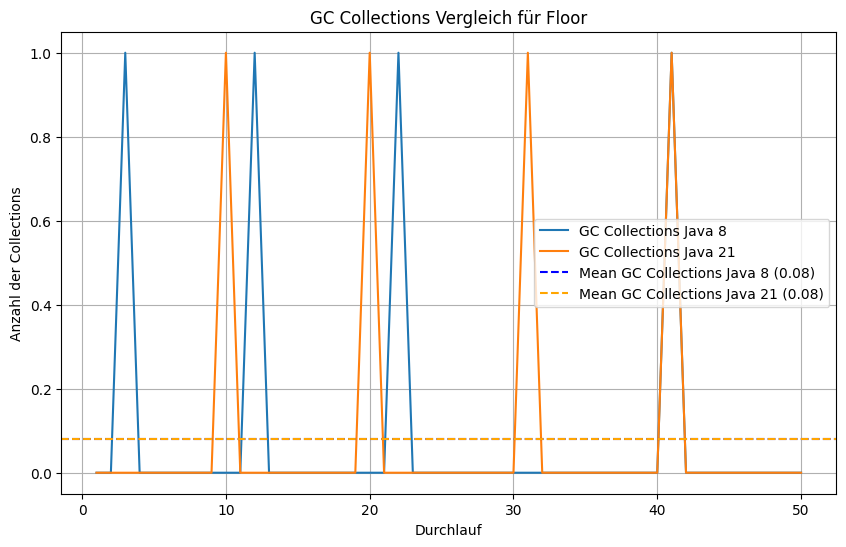

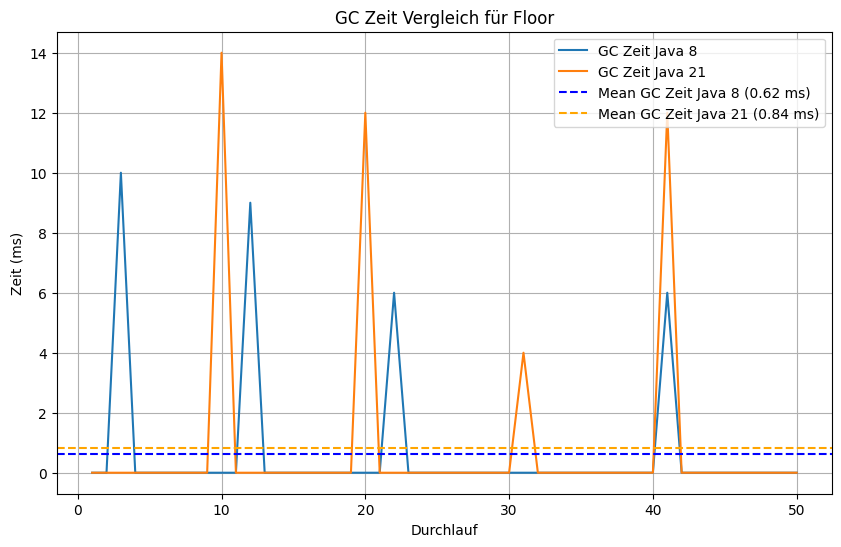

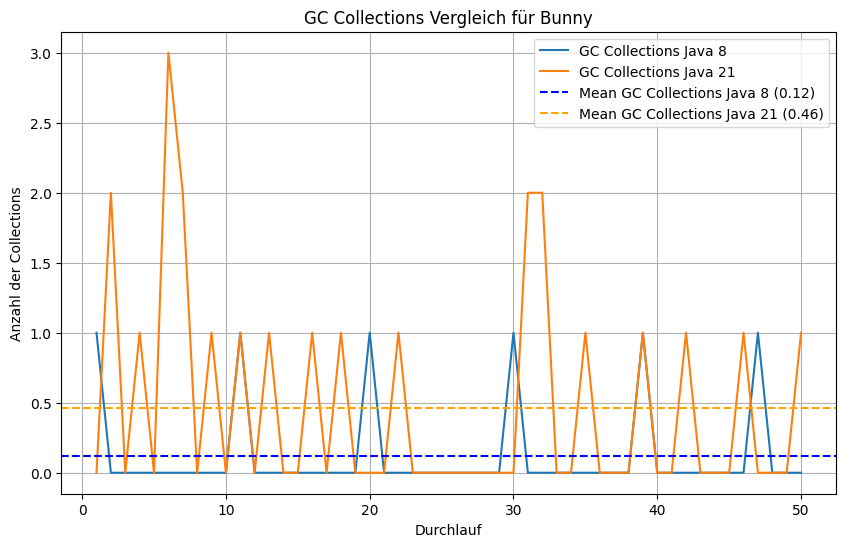

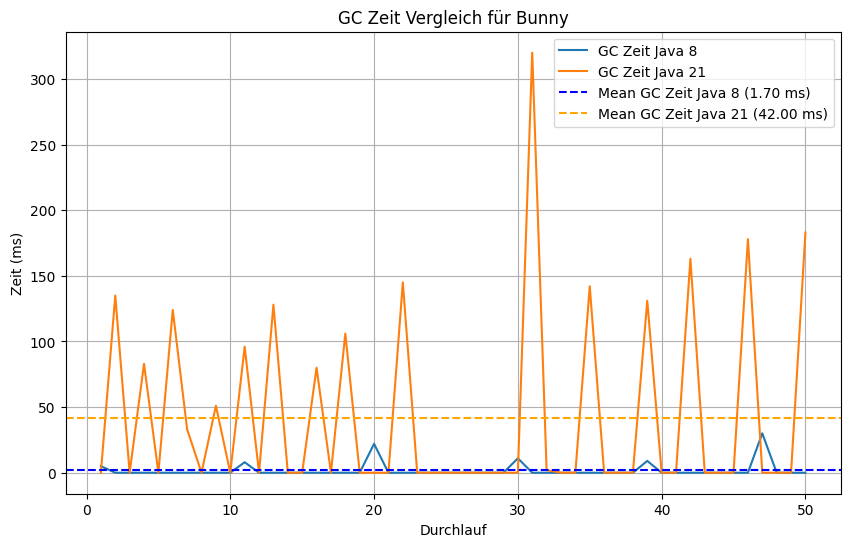

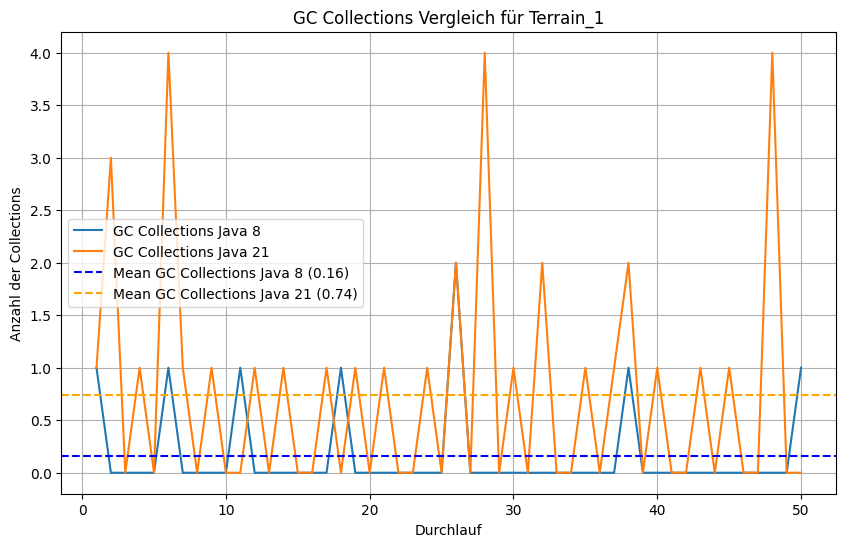

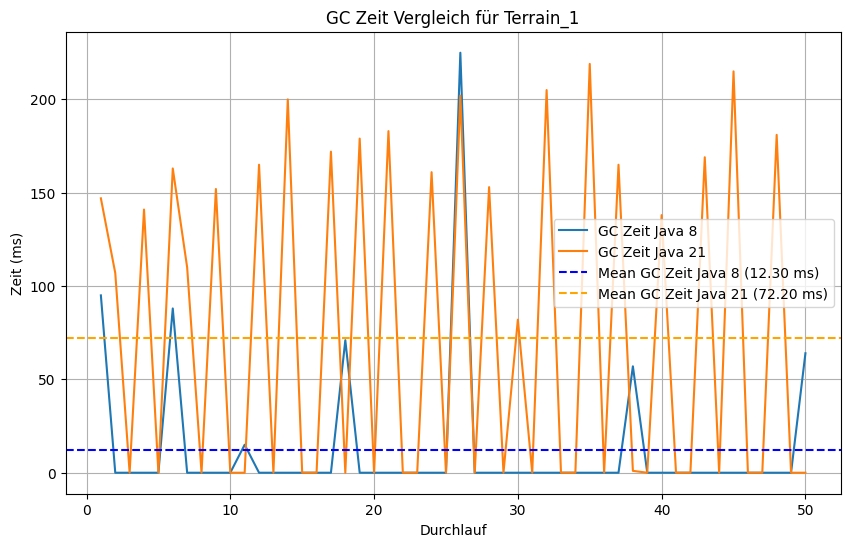

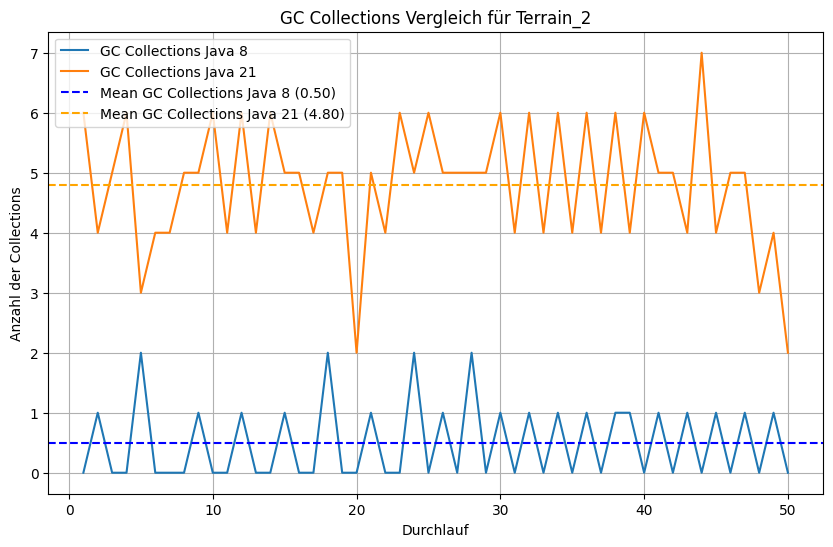

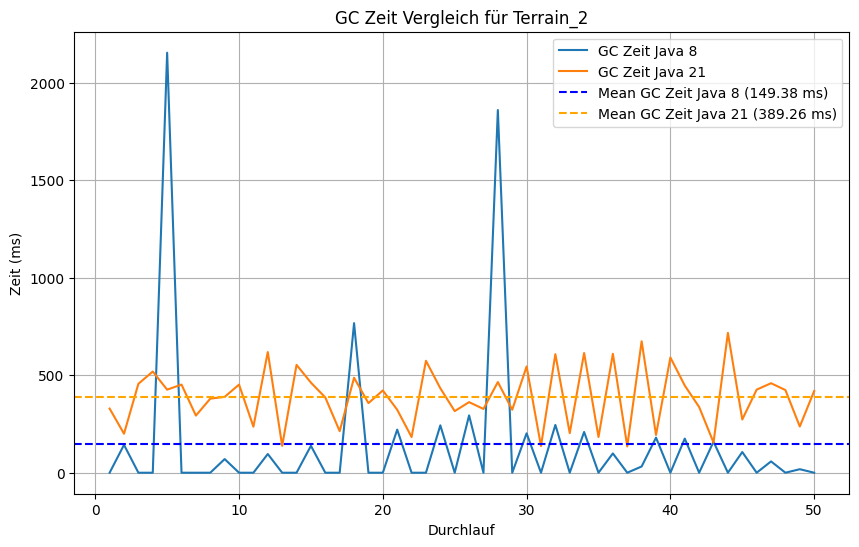

In [8]:
# Funktion zum Erstellen und Speichern der Vergleichsplots mit Mittelwerten
def create_comparison_plots(dataset_name, df):
    # Berechnen der Mittelwerte
    mean_gc_collections_8 = df['GC_Collections_8'].mean()
    mean_gc_collections_21 = df['GC_Collections_21'].mean()
    mean_gc_zeit_8 = df['GC_Zeit_8'].mean()
    mean_gc_zeit_21 = df['GC_Zeit_21'].mean()
    
    # Plot für GC_Collections_8 vs GC_Collections_21
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['GC_Collections_8'], label='GC Collections Java 8')
    plt.plot(df.index, df['GC_Collections_21'], label='GC Collections Java 21')
    plt.axhline(mean_gc_collections_8, color='blue', linestyle='--', label=f'Mean GC Collections Java 8 ({mean_gc_collections_8:.2f})')
    plt.axhline(mean_gc_collections_21, color='orange', linestyle='--', label=f'Mean GC Collections Java 21 ({mean_gc_collections_21:.2f})')
    plt.xlabel('Durchlauf')
    plt.ylabel('Anzahl der Collections')
    plt.title(f'GC Collections Vergleich für {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'performance_comparison/gc_collections_comparison_{dataset_name}.png')
    plt.show()
    
    # Plot für GC_Zeit_8 vs GC_Zeit_21
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['GC_Zeit_8'], label='GC Zeit Java 8')
    plt.plot(df.index, df['GC_Zeit_21'], label='GC Zeit Java 21')
    plt.axhline(mean_gc_zeit_8, color='blue', linestyle='--', label=f'Mean GC Zeit Java 8 ({mean_gc_zeit_8:.2f} ms)')
    plt.axhline(mean_gc_zeit_21, color='orange', linestyle='--', label=f'Mean GC Zeit Java 21 ({mean_gc_zeit_21:.2f} ms)')
    plt.xlabel('Durchlauf')
    plt.ylabel('Zeit (ms)')
    plt.title(f'GC Zeit Vergleich für {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'performance_comparison/gc_time_comparison_{dataset_name}.png')
    plt.show()

# Laden und Erstellen der Vergleichsplots für jedes Datenset
for dataset_name in datasets_names:
    df = pd.read_csv(f'combined_data/gc_{dataset_name}_combined_data.csv', index_col=0)
    create_comparison_plots(dataset_name, df)

<h3>Statistische Analyse mittels Mann-Whitney-U-Test</h3>

In [9]:
# Funktion zum Durchführen des Mann-Whitney-U-Tests und Speichern der Ergebnisse
def perform_mann_whitney_u_test(dataset_name, df):
    results = {}
    
    # Mann-Whitney-U-Test für GC_Collections
    collections_stat, collections_p_value = mannwhitneyu(df['GC_Collections_8'], df['GC_Collections_21'])
    results['GC_Collections'] = {'statistic': collections_stat, 'p_value': collections_p_value}
    
    # Mann-Whitney-U-Test für GC_Zeit
    zeit_stat, zeit_p_value = mannwhitneyu(df['GC_Zeit_8'], df['GC_Zeit_21'])
    results['GC_Zeit'] = {'statistic': zeit_stat, 'p_value': zeit_p_value}
    
    return results

# Funktion zum Bewerten und Ausgeben der Testergebnisse
def evaluate_results(dataset_name, test_results, df):
    significance_level = 0.05
    evaluations = []
    
    for metric in ['GC_Collections', 'GC_Zeit']:
        p_value = test_results[metric]['p_value']
        mean_java8 = df[f'{metric}_8'].mean()
        mean_java21 = df[f'{metric}_21'].mean()
        evaluations.append(f"Mittelwert {metric} Java 8: {mean_java8:.2f}, Mittelwert {metric} Java 21: {mean_java21:.2f}")
        if p_value < significance_level:
            better_version = 'Java 21' if mean_java21 < mean_java8 else 'Java 8'
            evaluations.append(f"{metric}: Signifikante Unterschiede festgestellt. Bessere Leistung: {better_version}.")
        else:
            evaluations.append(f"{metric}: Keine signifikanten Unterschiede festgestellt.")
        
    
    return evaluations

# Durchführen des Mann-Whitney-U-Tests für jedes Datenset und Ausgabe der Ergebnisse
for dataset_name in datasets_names:
    df = pd.read_csv(f'combined_data/gc_{dataset_name}_combined_data.csv', index_col=0)
    test_results = perform_mann_whitney_u_test(dataset_name, df)
    
    print(f"Ergebnisse des Mann-Whitney-U-Tests für {dataset_name}:")
    for metric, result in test_results.items():
        print(f"{metric} - Statistik: {result['statistic']}, p-Wert: {result['p_value']}")
    
    evaluations = evaluate_results(dataset_name, test_results, df)
    for evaluation in evaluations:
        print(evaluation)
    print()

Ergebnisse des Mann-Whitney-U-Tests für Sphere:
GC_Collections - Statistik: 1225.0, p-Wert: 0.3270861186553847
GC_Zeit - Statistik: 1225.0, p-Wert: 0.3270861186553847
Mittelwert GC_Collections Java 8: 0.00, Mittelwert GC_Collections Java 21: 0.02
GC_Collections: Keine signifikanten Unterschiede festgestellt.
Mittelwert GC_Zeit Java 8: 0.00, Mittelwert GC_Zeit Java 21: 0.08
GC_Zeit: Keine signifikanten Unterschiede festgestellt.

Ergebnisse des Mann-Whitney-U-Tests für Floor:
GC_Collections - Statistik: 1250.0, p-Wert: 1.0
GC_Zeit - Statistik: 1246.0, p-Wert: 0.959095311230852
Mittelwert GC_Collections Java 8: 0.08, Mittelwert GC_Collections Java 21: 0.08
GC_Collections: Keine signifikanten Unterschiede festgestellt.
Mittelwert GC_Zeit Java 8: 0.62, Mittelwert GC_Zeit Java 21: 0.84
GC_Zeit: Keine signifikanten Unterschiede festgestellt.

Ergebnisse des Mann-Whitney-U-Tests für Bunny:
GC_Collections - Statistik: 960.0, p-Wert: 0.006491134230268323
GC_Zeit - Statistik: 930.0, p-Wert: 0.00